In [24]:
import pandas as pd
import numpy as np
# Add these imports for stopwords
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk_available = True


pd.options.display.max_columns = None

# Load the data with embeddings (already segmented)
AT_combined = pd.read_pickle(r"data folder\AT\AT_final.pkl")
AT_combined.drop(columns=['Segment_ID'], inplace=True)

HR_combined= pd.read_pickle(r"data folder\HR\HR_final.pkl")
HR_combined.drop(columns=['Segment_ID'], inplace=True)

GB = pd.read_pickle(r"data folder\GB\GB_final.pkl")

print(f"✅ Loaded data: {AT_combined.shape}")
print(f"✅ Loaded data: {HR_combined.shape}")
print(f"✅ Loaded data: {GB.shape}")

✅ Loaded data: (231759, 32)
✅ Loaded data: (504338, 32)
✅ Loaded data: (670912, 29)


In [25]:
# === BERTOPIC SETUP WITH GUIDED TOPICS ===
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP
from hdbscan import HDBSCAN
import openai
import os
from dotenv import load_dotenv
import time
import gc  # For garbage collection
from tqdm import tqdm  # Add tqdm for progress tracking

# Load environment variables
load_dotenv()

# Define the 22 target topic categories
label_dict = {
    "Education": "Issues related to educational policies, primary and secondary schools, student loans and education finance, the regulation of colleges and universities, school reforms, teachers, vocational training, evening schools, safety in schools, efforts to improve educational standards, and issues related to libraries, dictionaries, teaching material, research in education",
    "Technology": "Issues related to science and technology transfer and international science cooperation, research policy, government space programs and space exploration, telephones and telecommunication regulation, broadcast media (television, radio, newspapers, films), weather forecasting, geological surveys, computer industry, cyber security.",
    "Health": "Issues related to health care, health care reforms, health insurance, drug industry, medical facilities, medical workers, disease prevention, treatment, and health promotion, drug and alcohol abuse, mental health, research in medicine, medical liability and unfair medical practices.",
    "Environment": "Issues related to environmental policy, drinking water safety, all kinds of pollution (air, noise, soil), waste disposal, recycling, climate change, outdoor environmental hazards (e.g., asbestos), species and forest protection, marine and freshwater environment, hunting, regulation of laboratory or performance animals, land and water resource conservation, research in environmental technology.",
    "Housing": "Issues related to housing, urban affairs and community development, housing market, property tax, spatial planning, rural development, location permits, construction inspection, illegal construction, industrial and commercial building issues, national housing policy, housing for low-income individuals, rental housing, housing for the elderly, e.g., nursing homes, housing for the homeless and efforts to reduce homelessness, research related to housing, construction inspection, illegal construction, industrial and commercial building issues, national housing policy, housing for low-income individuals, rental housing, housing for the elderly, e.g., nursing homes, housing for the homeless and efforts to reduce homelessness, research related to housing.",
    "Labor": "Issues related to labor, employment, employment programs, employee benefits, pensions and retirement accounts, minimum wage, labor law, job training, labor unions, worker safety and protection, youth employment and seasonal workers.",
    "Defense": "Issues related to defense policy, military intelligence, espionage, weapons, military personnel, reserve forces, military buildings, military courts, nuclear weapons, civil defense, including firefighters and mountain rescue services, homeland security, military aid or arms sales to other countries, prisoners of war and collateral damage to civilian populations, military nuclear and hazardous waste disposal and military environmental compliance, defense alliances and agreements, direct foreign military operations, claims against military, defense research.",
    "Government Operations": "Issues related to general government operations, the work of multiple departments, public employees, postal services, nominations and appointments, national mints, medals, and commemorative coins, management of government property, government procurement and contractors, public scandal and impeachment, claims against the government, the state inspectorate and audit, anti-corruption policies, regulation of political campaigns, political advertising and voter registration, census and statistics collection by government; issues related to local government, capital city and municipalities, including decentralization; issues related to national holidays.",
    "Social Welfare": "Issues related to social welfare policy, the Ministry of Social Affairs, social services, poverty assistance for low-income families and for the elderly, parental leave and child care, assistance for people with physical or mental disabilities, including early retirement pension, discounts on public services, volunteer associations (e.g., Red Cross), charities, and youth organizations.",
    "Macroeconomics": "Issues related to domestic macroeconomic policy, such as the state and prospect of the national economy, economic policy,inflation, interest rates, monetary policy, cost of living, unemployment rate, national budget, public debt, price control, tax enforcement, industrial revitalization and growth.",
    "Domestic Commerce": "Issues related to banking, finance and internal commerce, including stock exchange, investments, consumer finance, mortgages, credit cards, insurance availability and cost, accounting regulation, personal, commercial, and municipal bankruptcies, programs to promote small businesses, copyrights and patents, intellectual property, natural disaster preparedness and relief, consumer safety; regulation and promotion of tourism, sports, gambling, and personal fitness; domestic commerce research.",
    "Civil Rights": "Issues related to civil rights and minority rights, discrimination towards races, gender, sexual orientation, handicap, and other minorities, voting rights, freedom of speech, religious freedoms, privacy rights, protection of personal data, abortion rights, anti-government activity groups (e.g., local insurgency groups), religion and the Church.",
    "International Affairs": "Issues related to international affairs, foreign policy and relations to other countries, issues related to the Ministry of Foreign Affairs, foreign aid, international agreements (such as Kyoto agreement on the environment, the Schengen agreement), international organizations (including United Nations, UNESCO, International Olympic Committee, International Criminal Court), NGOs, issues related to diplomacy, embassies, citizens abroad; issues related to border control; issues related to international finance, including the World Bank and International Monetary Fund, the financial situation of the EU; issues related to a foreign country that do not impact the home country; issues related to human rights in other countries, international terrorism.",
    "Transportation": "Issues related to mass transportation construction and regulation, bus transport, regulation related to motor vehicles, road construction, maintenance and safety, parking facilities, traffic accidents statistics, air travel, rail travel, rail freight, maritime transportation, inland waterways and channels, transportation research and development.",
    "Immigration": "Issues related to immigration, refugees, and citizenship, integration issues, regulation of residence permits, asylum applications; criminal offences and diseases caused by immigration.",
    "Law and Crime": "Issues related to the control, prevention, and impact of crime; all law enforcement agencies, including border and customs, police, court system, prison system; terrorism, white collar crime, counterfeiting and fraud, cyber-crime, drug trafficking, domestic violence, child welfare, family law, juvenile crime.",
    "Agriculture": " Issues related to agriculture policy, fishing, agricultural foreign trade, food marketing, subsidies to farmers, food inspection and safety, animal and crop disease, pest control and pesticide regulation, welfare for animals in farms, pets, veterinary medicine, agricultural research.",
    "Foreign Trade": "Issues related to foreign trade, trade negotiations, free trade agreements, import regulation, export promotion and regulation, subsidies, private business investment and corporate development, competitiveness, exchange rates, the strength of national currency in comparison to other currencies, foreign investment and sales of companies abroad.",
    "Culture": "Issues related to cultural policies, Ministry of Culture, public spending on culture, cultural employees, issues related to support of theatres and artists; allocation of funds from the national lottery, issues related to cultural heritage.",
    "Public Lands": "Issues related to national parks, memorials, historic sites, and protected areas, including the management and staffing of cultural sites; museums; use of public lands and forests, establishment and management of harbors and marinas; issues related to flood control, forest fires, livestock grazing.",
    "Energy": "Issues related to energy policy, electricity, regulation of electrical utilities, nuclear energy and disposal of nuclear waste, natural gas and oil, drilling, oil spills, oil and gas prices, heat supply, shortages and gasoline regulation, coal production, alternative and renewable energy, energy conservation and energy efficiency, energy research.",
    "Other": "Other topics not mentioning policy agendas, including the procedures of parliamentary meetings, e.g., points of order, voting procedures, meeting logistics; interpersonal speech, e.g., greetings, personal stories, tributes, interjections, arguments between the members; rhetorical speech, e.g., jokes, literary references."
}


# STOP WORDS

# Enhanced stopword lists with comprehensive coverage
english_custom_stopwords = [
    'mr', 'mrs', 'ms', 'dr', 'madam', 'honorable', 'honourable', 'member', 'members', 'vp', 'sp', 'fp', 
    'minister', 'speaker', 'deputy', 'president', 'chairman', 'chair', 'schilling', 
    'secretary', 'lord', 'lady', 'question', 'order', 'point', 'debate', 'motion', 'amendment',
    'congratulations', 'congratulate', 'thanks', 'thank', 'say', 'one', 'want', 'know', 'think', 
    'believe', 'see', 'go', 'come', 'give', 'take', 'people', 'federal', 'government', 'austria', 
    'austrian', 'committee', 'call', 'said', 'already', 'please', 'request', 'proceed', 'reading',
    'course', 'welcome', 'council', 'open', 'written', 'contain', 'items', 'item', 'yes', 'no', 
    'following', 'next', 'speech', 'year', 'years', 'state', 'also', 'would', 'like', 'may', 'must', 
    'upon', 'indeed', 'session', 'meeting', 'report', 'commission', 'behalf', 'gentleman', 'gentlemen', 
    'ladies', 'applause', 'group', 'colleague', 'colleagues', 'issue', 'issues', 'chancellor', 'court', 
    'ask', 'answer', 'reply', 'regard', 'regarding', 'regards', 'respect', 'respectfully', 'sign', 
    'shall', 'procedure', 'declare', 'hear', 'minutes', 'speaking', 'close', 'abg', 'mag', 'orf', 'wait'
]

# Comprehensive German stopwords (NLTK + custom parliamentary terms)
german_nltk_stopwords = stopwords.words('german')

german_custom_stopwords = [
    # Basic German stopwords
    'der', 'die', 'das', 'und', 'in', 'zu', 'den', 'mit', 'von', 'für', 
    'auf', 'ist', 'im', 'sich', 'eine', 'sie', 'dem', 'nicht', 'ein', 'als',
    'auch', 'es', 'an', 'werden', 'aus', 'er', 'hat', 'dass', 'wir', 'ich',
    'haben', 'sind', 'kann', 'sehr', 'meine', 'muss', 'doch', 'wenn', 'sein',
    'dann', 'weil', 'bei', 'nach', 'so', 'oder', 'aber', 'vor', 'über', 'noch',
    'nur', 'wie', 'war', 'waren', 'wird', 'wurde', 'wurden', 'ihr', 'ihre',
    'ihren', 'seiner', 'seine', 'seinem', 'seinen', 'dieser', 'diese', 'dieses',
    'durch', 'ohne', 'gegen', 'unter', 'zwischen', 'während', 'bis', 'seit',
    'danke', 'bitte', 'gern', 'gern geschehen', 'nichts zu danken', 
    # Austrian parliamentary terms
    'abgeordnete', 'abgeordneten', 'bundesregierung',
    'bundeskanzler', 'nationalrat', 'bundesrat', 'parlament', 'fraktion',
    'ausschuss', 'sitzung', 'präsident', 'vizepräsident', 'minister',
    'staatssekretär', 'klubobmann', 'antrag', 'anfrage', 'interpellation',
    'dringliche', 'aktuelle', 'stunde', 'debatte', 'abstimmung', 'beschluss',
    'gesetz', 'novelle', 'verordnung', 'regierungsvorlage', 'initiativantrag',
    'danke', 'dankeschön', 'geschätzte', 'kolleginnen', 'kollegen', 'hohes'
]

# Comprehensive Croatian stopwords from GitHub repository + parliamentary terms
croatian_github_stopwords = [
    'a', 'ako', 'ali', 'bi', 'bih', 'bila', 'bili', 'bilo', 'bio', 'bismo', 
    'biste', 'biti', 'bumo', 'da', 'do', 'duž', 'ga', 'hoće', 'hoćemo', 
    'hoćete', 'hoćeš', 'hoću', 'i', 'iako', 'ih', 'ili', 'iz', 'ja', 'je', 
    'jedna', 'jedne', 'jedno', 'jer', 'jesam', 'jesi', 'jesmo', 'jest', 
    'jeste', 'jesu', 'jim', 'joj', 'još', 'ju', 'kada', 'kako', 'kao', 
    'koja', 'koje', 'koji', 'kojima', 'koju', 'kroz', 'li', 'me', 'mene', 
    'meni', 'mi', 'mimo', 'moj', 'moja', 'moje', 'mu', 'na', 'nad', 'nakon', 
    'nam', 'nama', 'nas', 'naš', 'naša', 'naše', 'našeg', 'ne', 'nego', 
    'neka', 'neki', 'nekog', 'neku', 'nema', 'netko', 'neće', 'nećemo', 
    'nećete', 'nećeš', 'neću', 'nešto', 'ni', 'nije', 'nikoga', 'nikoje', 
    'nikoju', 'nisam', 'nisi', 'nismo', 'niste', 'nisu', 'njega', 'njegov', 
    'njegova', 'njegovo', 'njemu', 'njezin', 'njezina', 'njezino', 'njih', 
    'njihov', 'njihova', 'njihovo', 'njim', 'njima', 'njoj', 'nju', 'no', 
    'o', 'od', 'odmah', 'on', 'ona', 'oni', 'ono', 'ova', 'pa', 'pak', 
    'po', 'pod', 'pored', 'prije', 's', 'sa', 'sam', 'samo', 'se', 'sebe', 
    'sebi', 'si', 'smo', 'ste', 'su', 'sve', 'svi', 'svog', 'svoj', 'svoja', 
    'svoje', 'svom', 'ta', 'tada', 'taj', 'tako', 'te', 'tebe', 'tebi', 
    'ti', 'to', 'toj', 'tome', 'tu', 'tvoj', 'tvoja', 'tvoje', 'u', 'uz', 
    'vam', 'vama', 'vas', 'vaš', 'vaša', 'vaše', 'već', 'vi', 'vrlo', 'za', 
    'zar', 'će', 'ćemo', 'ćete', 'ćeš', 'ću', 'što'
]

croatian_parliamentary_stopwords = [
    # Previous custom Croatian stopwords + parliamentary terms
    'zastupnik', 'zastupnica', 'zastupnici', 'hvala', 'sabor', 'hrvatska', 
    'vlada', 'molim', 'gospodin', 'gospođa', 'premijer', 'predsjednik',
    'predsjednica', 'ministar', 'ministrica', 'državni', 'tajnik', 'tajnica',
    'odbor', 'sjednica', 'rasprava', 'prijedlog', 'zakon', 'odluka',
    'glasovanje', 'amandman', 'interpelacija', 'pitanje', 'odgovor',
    'klupski', 'obnašatelj', 'dužnosti', 'potpredsjednik', 'potpredsjednica',
    'kolegice', 'kolege', 'dame', 'gospodo', 'poštovani', 'poštovana', 
    
]

# Combine all stopwords
all_german_stopwords = list(set(german_nltk_stopwords + german_custom_stopwords))
all_croatian_stopwords = list(set(croatian_github_stopwords + croatian_parliamentary_stopwords))
all_english_stopwords = list(set(list(ENGLISH_STOP_WORDS) + english_custom_stopwords))

print(f"📚 Stopwords loaded:")
print(f"  • English: {len(all_english_stopwords)} words")
print(f"  • German: {len(all_german_stopwords)} words")
print(f"  • Croatian: {len(all_croatian_stopwords)} words")

print(f"🎯 Target categories: {len(label_dict.keys())} topics")

📚 Stopwords loaded:
  • English: 417 words
  • German: 274 words
  • Croatian: 219 words
🎯 Target categories: 22 topics


Some speeches do not address a policy topic, for example, when speakers discuss meeting logistics, share personal stories, or engage in arguments. To account for these cases, we introduced an additional
label, Other.

For downstream applications, we recommend incorporating a confidence-based filtering mechanism to
improve the reliability of model predictions. Specifically, for annotating the entire ParlaMint 4.1 corpus
collection with the final ParlaCAP classifier, we apply a confidence threshold of 0.60 and label any
instance below this threshold as Mix

In [ ]:
# === SEGMENT-LEVEL TOPIC MODELING FUNCTIONS ===
from openai import OpenAI

def generate_topic_name(topic_words):
    """Generate a descriptive topic name using OpenAI API - always in English."""
    
    keywords_str = ', '.join(topic_words)
    
    prompt = f"""Generate a clear, concise name for a parliamentary debate topic based on these keywords: {keywords_str} which were the output of BERTopic, tf-idf etc.

Requirements:
- Maximum 3 words
- Noun-based, no action words (avoid: improving, achieving, strategies, developing, etc.)
- Direct topic name
- Parliamentary/political debate sitting context
- ALWAYS respond in English, even if the input keywords are in other languages (German, Croatian, etc.)
- If keywords are in foreign languages, translate the concept to English

RESPONSE: Topic name only in English."""

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You generate concise parliamentary topic names in English only. Use nouns only, no action words. Always respond in English regardless of input language. If keywords are in foreign languages, understand their meaning and create an appropriate English topic name."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=15
        )
        
    topic_name = response.choices[0].message.content.strip()
    topic_name = topic_name.replace('"', '').replace("'", "").strip()
        
    return topic_name

def classify_topic_to_22_categories(topic_words, topic_id=-1):
    """Classify topic into one of the 22 predefined categories using OpenAI API."""
    
    keywords_str = ', '.join(topic_words)
    
    # Create detailed categories list with descriptions
    categories_detailed = '\n'.join([f"• {cat}: {desc}" for cat, desc in label_dict.items()])
    
    prompt = f"""Classify this parliamentary topic into ONE category from the list below.

TOPIC KEYWORDS: {keywords_str}

CATEGORIES WITH DESCRIPTIONS:
{categories_detailed}

Instructions:
- Choose the category that best matches the topic keywords
- Consider the detailed descriptions to make the most accurate classification
- If keywords don't clearly fit any category, choose "Other"

RESPONSE: Category name only (exactly as listed above)."""

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an expert classifier of parliamentary topics, environment is parliamentary debates in conversational style.  You must classify topics into exactly one of the 22 predefined categories based on keywords and category descriptions. Respond with the exact category name only."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.1,
        max_tokens=40
    )
    
    classification = response.choices[0].message.content.strip()
    classification = classification.replace('"', '').replace("'", "").strip()
    
    # Validate that the classification is in our predefined categories
    if classification not in label_dict.keys():
        print(f"⚠️ Warning: OpenAI returned '{classification}' which is not in predefined categories. Defaulting to 'Other'")
        classification = "Other"
    
    return classification

def run_bertopic_on_segments(df, dataset_name, language, text_column, segment_id_column, embedding_column, min_cluster_size=15):
    """Run BERTopic on segment-level data using pre-computed embeddings."""
    print(f"\n🔍 Running BERTopic for {dataset_name} ({language}) - Segment Level")
    print(f"   Text column: {text_column}")
    print(f"   Segment ID column: {segment_id_column}")
    print(f"   Embedding column: {embedding_column}")
    print(f"   Min cluster size: {min_cluster_size}")
    
    # Group by segment and aggregate text
    print("📝 Grouping text by segments...")
    grouped_data = df.groupby(segment_id_column).agg({
        text_column: ' '.join,
        embedding_column: 'first'
    }).reset_index()
    
    # Extract embeddings and documents
    documents = grouped_data[text_column].tolist()
    embeddings_raw = grouped_data[embedding_column].tolist()
    segment_ids = grouped_data[segment_id_column].tolist()
    
    # Convert to numpy array
    embeddings = np.array(embeddings_raw)
    print(f"📊 Prepared {len(documents)} segments for topic modeling")
    print(f"   Embedding shape: {embeddings.shape}")
    
    # Set up language-specific stopwords
    stopwords_list = {
        "english": all_english_stopwords,
        "german": all_german_stopwords,
        "croatian": all_croatian_stopwords
    }.get(language, all_english_stopwords)
    
    # Set up BERTopic components with improved parameters to reduce outliers
    vectorizer_model = CountVectorizer(
        stop_words=stopwords_list,
        ngram_range=(1, 2),
        min_df=3,  # Reduced from 5 to include more words
        max_df=0.95,
        lowercase=True,
        strip_accents='unicode'
    )
    
    umap_model = UMAP(
        n_neighbors=15,
        n_components=10,
        min_dist=0.0,
        metric='cosine',
        random_state=42,
        low_memory=True,
        n_jobs=1
    )
    
    # Adjusted HDBSCAN parameters to reduce outliers
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size, 
        #min_samples=3, 
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True,
        cluster_selection_epsilon=0.05  # Reduced from 0.1 to reduce outliers (smaller = less outliers)
    )
    
    # Initialize BERTopic
    topic_model = BERTopic(
        top_n_words=15,
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=True,
        calculate_probabilities=True,
        embedding_model=None
    )
    
    print("🤖 Fitting BERTopic model...")
    embeddings = embeddings.astype(np.float32)
    
    topics, probabilities = topic_model.fit_transform(documents, embeddings)
    
    # Count outliers - convert to numpy array first to handle edge cases
    topics_array = np.array(topics)
    outlier_count = (topics_array == -1).sum()
    total_count = len(topics_array)
    outlier_percentage = (outlier_count / total_count) * 100
    
    print(f"✅ Topic modeling completed!")
    print(f"   Found {len(set(topics))} topics (including noise: {-1 in topics})")
    print(f"   Outliers (topic -1): {outlier_count}/{total_count} ({outlier_percentage:.1f}%)")
    
    # Analyze topic assignment probabilities (keep for potential future use)
    max_probs = np.max(probabilities, axis=1)
    print(f"   Probability stats: min={max_probs.min():.3f}, mean={max_probs.mean():.3f}, max={max_probs.max():.3f}")
    
    # Get topic information
    topic_info = topic_model.get_topic_info()
    print(f"   Topic distribution: {topic_info['Count'].describe()}")
    
    # Process topics with OpenAI API
    print("\n🤖 Processing topics with OpenAI API...")
    topic_names = {}
    topic_categories = {}
    
    for idx, row in topic_info.iterrows():
        topic_id = row['Topic']
        
        # Handle outliers (topic -1) separately
        if topic_id == -1:
            print(f"Processing topic {topic_id}: [OUTLIERS/NOISE]")
            topic_names[topic_id] = "Mixed Content"
            topic_categories[topic_id] = "Other"
            print(f"  → Name: Mixed Content")
            print(f"  → Category: Other (automatically assigned for outliers)")
            continue
        
        topic_words = [word for word, _ in topic_model.get_topic(topic_id)]
        
        print(f"Processing topic {topic_id}: {topic_words}")
        
        # Generate topic name
        topic_name = generate_topic_name(topic_words)
        topic_names[topic_id] = topic_name
        
        # Classify into 22 categories
        category = classify_topic_to_22_categories(topic_words, topic_id)
        topic_categories[topic_id] = category
        
        print(f"  → Name: {topic_name}")
        print(f"  → Category: {category}")
        
        time.sleep(0.3)
    
    # Create mapping dataframe with probabilities (no filtering applied)
    segment_topics = pd.DataFrame({
        segment_id_column: segment_ids,
        f'Segment_Topic_{dataset_name}_{language}': topics,  # Use original topics
        f'Segment_Subtopic_{dataset_name}_{language}': [topic_names.get(t, "Noise") for t in topics],
        f'Segment_Category_{dataset_name}_{language}': [topic_categories.get(t, "Other") for t in topics],
        f'Segment_Topic_Confidence_{dataset_name}_{language}': max_probs  # Keep probabilities for potential future use
    })
    
    # Merge back to original dataframe
    df_result = df.merge(segment_topics, on=segment_id_column, how='left')
    
    print(f"✅ Successfully processed {dataset_name} ({language}) segments")
    print(f"   Added columns: Segment_Topic, Segment_Subtopic, Segment_Category")
    
    return df_result, topic_model, topic_info

# Run the model

British

In [ ]:
# === PROCESS GB DATASET (ENGLISH ONLY) ===
print("🇬🇧 Processing British Parliament (GB) - Segment Level...")

# Run segment-level topic modeling for GB with custom cluster size
GB_processed, gb_model, gb_topics = run_bertopic_on_segments(
    GB, 
    dataset_name="GB", 
    language="english",
    text_column="Text",
    segment_id_column="Segment_ID",
    embedding_column="segment_embeddings_english",
    min_cluster_size=10
)

# Add the required columns (my_topic and my_subtopic)
GB_processed['my_subtopic'] = GB_processed[f'Segment_Subtopic_GB_english']
GB_processed['my_topic'] = GB_processed[f'Segment_Category_GB_english']
print("✅ Added my_topic and my_subtopic columns to GB dataset")

🇬🇧 Processing British Parliament (GB) - Segment Level...

🔍 Running BERTopic for GB (english) - Segment Level
   Text column: Text
   Segment ID column: Segment_ID
   Embedding column: segment_embeddings_english
   Min cluster size: 20
   Mix percentage (lowest confidence): 10.0%
📝 Grouping text by segments...
📊 Prepared 33381 segments for topic modeling
   Embedding shape: (33381, 1024)
🤖 Fitting BERTopic model...
📊 Prepared 33381 segments for topic modeling
   Embedding shape: (33381, 1024)
🤖 Fitting BERTopic model...


2025-10-05 18:46:56,825 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-05 18:47:33,114 - BERTopic - Dimensionality - Completed ✓
2025-10-05 18:47:33,136 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 18:47:33,114 - BERTopic - Dimensionality - Completed ✓
2025-10-05 18:47:33,136 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 18:49:58,380 - BERTopic - Cluster - Completed ✓
2025-10-05 18:49:58,380 - BERTopic - Cluster - Completed ✓
2025-10-05 18:49:58,422 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 18:49:58,422 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 18:53:11,849 - BERTopic - Representation - Completed ✓
2025-10-05 18:53:11,849 - BERTopic - Representation - Completed ✓


✅ Topic modeling completed!
   Found 276 topics (including noise: True)
   Outliers (topic -1): 9412/33381 (28.2%)
   Probability stats: min=0.000, mean=0.291, max=1.000

🔍 Applying confidence-based filtering...
   Percentage-based (10.0%): 3339 segments (threshold: 0.007)
   Using bottom 10.0% method: 3339 segments marked as Mix
   Topic distribution: count     276.000000
mean      120.945652
std       580.735184
min        20.000000
25%        31.000000
50%        49.000000
75%        93.250000
max      9412.000000
Name: Count, dtype: float64

🤖 Processing topics with OpenAI API...
Processing topic -1: [OUTLIERS/NOISE]
  → Name: Mixed Content
  → Category: Other (automatically assigned for outliers)
Processing topic 0: ['referendum', 'right hon', 'voted', 'withdrawal', 'customs', 'withdrawal agreement', 'article 50', 'negotiations', 'backstop', 'customs union', 'single market', 'hon learned', 'negotiating', 'extension', 'exit']
  → Name: Withdrawal Agreement Debate
  → Category: Inte

# Austrian

In [ ]:
# === PROCESS AT_COMBINED DATASET (ENGLISH AND GERMAN) ===
print("\n🇦🇹 Processing Austrian Parliament (AT) - Segment Level...")

# First run: English
print("\n📊 AT - English processing...")
AT_processed, at_en_model, at_en_topics = run_bertopic_on_segments(
    AT_combined, 
    dataset_name="AT", 
    language="english",
    text_column="Text",
    segment_id_column="Segment_ID_english",
    embedding_column="segment_embeddings_english",
    min_cluster_size=5  
)

# Second run: German
print("\n📊 AT - German processing...")
AT_processed, at_de_model, at_de_topics = run_bertopic_on_segments(
    AT_processed,
    dataset_name="AT", 
    language="german",
    text_column="Text_native_language",
    segment_id_column="Segment_ID_english",
    embedding_column="segment_embeddings_native_language",
    min_cluster_size=5
)

# Add separate columns for both languages
AT_processed['my_subtopic_en'] = AT_processed[f'Segment_Subtopic_AT_english']
AT_processed['my_topic_en'] = AT_processed[f'Segment_Category_AT_english']
print("✅ Added my_topic_en and my_subtopic_en columns to AT dataset")

AT_processed['my_subtopic_native_language'] = AT_processed[f'Segment_Subtopic_AT_german']
AT_processed['my_topic_native_language'] = AT_processed[f'Segment_Category_AT_german']
print("✅ Added my_topic_native_language and my_subtopic_native_language columns to AT dataset")


🇦🇹 Processing Austrian Parliament (AT) - Segment Level...

📊 AT - English processing...

🔍 Running BERTopic for AT (english) - Segment Level
   Text column: Text
   Segment ID column: Segment_ID_english
   Embedding column: segment_embeddings_english
   Min cluster size: 10
   Mix percentage (lowest confidence): 10.0%
📝 Grouping text by segments...


2025-10-05 19:08:35,603 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


📊 Prepared 12529 segments for topic modeling
   Embedding shape: (12529, 1024)
🤖 Fitting BERTopic model...


2025-10-05 19:08:51,753 - BERTopic - Dimensionality - Completed ✓
2025-10-05 19:08:51,756 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:08:51,756 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:09:28,454 - BERTopic - Cluster - Completed ✓
2025-10-05 19:09:28,466 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:09:28,454 - BERTopic - Cluster - Completed ✓
2025-10-05 19:09:28,466 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:11:17,858 - BERTopic - Representation - Completed ✓
2025-10-05 19:11:17,858 - BERTopic - Representation - Completed ✓


✅ Topic modeling completed!
   Found 201 topics (including noise: True)
   Outliers (topic -1): 3778/12529 (30.2%)
   Probability stats: min=0.000, mean=0.320, max=1.000

🔍 Applying confidence-based filtering...
   Percentage-based (10.0%): 1253 segments (threshold: 0.013)
   Using bottom 10.0% method: 1253 segments marked as Mix
   Topic distribution: count     201.000000
mean       62.333333
std       273.716246
min        10.000000
25%        14.000000
50%        22.000000
75%        49.000000
max      3778.000000
Name: Count, dtype: float64

🤖 Processing topics with OpenAI API...
Processing topic -1: [OUTLIERS/NOISE]
  → Name: Mixed Content
  → Category: Other (automatically assigned for outliers)
Processing topic 0: ['students', 'universities', 'university', 'schools', 'teachers', 'educational', 'teaching', 'science', 'parents', 'teacher', 'student', 'studies', 'education policy', 'matura', 'higher education']
  → Name: Higher Education Policy
  → Category: Education
  → Name: Hig

2025-10-05 19:21:59,129 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


📊 Prepared 12529 segments for topic modeling
   Embedding shape: (12529, 1024)
🤖 Fitting BERTopic model...


2025-10-05 19:22:14,490 - BERTopic - Dimensionality - Completed ✓
2025-10-05 19:22:14,493 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:22:14,493 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:23:10,265 - BERTopic - Cluster - Completed ✓
2025-10-05 19:23:10,274 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:23:10,265 - BERTopic - Cluster - Completed ✓
2025-10-05 19:23:10,274 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:25:34,093 - BERTopic - Representation - Completed ✓
2025-10-05 19:25:34,093 - BERTopic - Representation - Completed ✓


✅ Topic modeling completed!
   Found 255 topics (including noise: True)
   Outliers (topic -1): 2672/12529 (21.3%)
   Probability stats: min=0.000, mean=0.372, max=1.000

🔍 Applying confidence-based filtering...
   Percentage-based (10.0%): 1253 segments (threshold: 0.015)
   Using bottom 10.0% method: 1253 segments marked as Mix
   Topic distribution: count     255.000000
mean       49.133333
std       174.967033
min        10.000000
25%        14.000000
50%        22.000000
75%        42.500000
max      2672.000000
Name: Count, dtype: float64

🤖 Processing topics with OpenAI API...
Processing topic -1: [OUTLIERS/NOISE]
  → Name: Mixed Content
  → Category: Other (automatically assigned for outliers)
Processing topic 0: ['patienten', 'rzte', 'gesundheitssystem', 'rasinger', 'arzt', 'versorgung', 'gesundheit', 'gesundheitspolitik', 'gesundheitswesen', 'ministerin', 'rzten', 'gesundheitsausschusses', 'frau ministerin', 'pumberger', 'patientinnen']
  → Name: Gesundheitsversorgung Patient

# Croatian

In [ ]:
# === PROCESS HR_COMBINED DATASET (ENGLISH AND CROATIAN) ===
print("\n🇭🇷 Processing Croatian Parliament (HR) - Segment Level...")

# First run: English
print("\n📊 HR - English processing...")
HR_processed, hr_en_model, hr_en_topics = run_bertopic_on_segments(
    HR_combined, 
    dataset_name="HR", 
    language="english",
    text_column="Text",
    segment_id_column="Segment_ID_english",
    embedding_column="segment_embeddings_english",
    min_cluster_size=10  
)

# Second run: Croatian
print("\n📊 HR - Croatian processing...")
HR_processed, hr_hr_model, hr_hr_topics = run_bertopic_on_segments(
    HR_processed,
    dataset_name="HR", 
    language="croatian",
    text_column="Text_native_language",
    segment_id_column="Segment_ID_english",
    embedding_column="segment_embeddings_native_language",
    min_cluster_size=10 
)

# Add separate columns for both languages
HR_processed['my_subtopic_en'] = HR_processed[f'Segment_Subtopic_HR_english']
HR_processed['my_topic_en'] = HR_processed[f'Segment_Category_HR_english']
print("✅ Added my_topic_en and my_subtopic_en columns to HR dataset")

HR_processed['my_subtopic_native_language'] = HR_processed[f'Segment_Subtopic_HR_croatian']
HR_processed['my_topic_native_language'] = HR_processed[f'Segment_Category_HR_croatian']
print("✅ Added my_topic_native_language and my_subtopic_native_language columns to HR dataset")


🇭🇷 Processing Croatian Parliament (HR) - Segment Level...

📊 HR - English processing...

🔍 Running BERTopic for HR (english) - Segment Level
   Text column: Text
   Segment ID column: Segment_ID_english
   Embedding column: segment_embeddings_english
   Min cluster size: 20
   Mix percentage (lowest confidence): 10.0%
📝 Grouping text by segments...


2025-10-05 19:39:25,065 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


📊 Prepared 25115 segments for topic modeling
   Embedding shape: (25115, 1024)
🤖 Fitting BERTopic model...


2025-10-05 19:39:54,850 - BERTopic - Dimensionality - Completed ✓
2025-10-05 19:39:54,852 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:39:54,852 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:42:08,101 - BERTopic - Cluster - Completed ✓
2025-10-05 19:42:08,116 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:42:08,101 - BERTopic - Cluster - Completed ✓
2025-10-05 19:42:08,116 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 19:44:57,130 - BERTopic - Representation - Completed ✓
2025-10-05 19:44:57,130 - BERTopic - Representation - Completed ✓


✅ Topic modeling completed!
   Found 255 topics (including noise: True)
   Outliers (topic -1): 5350/25115 (21.3%)
   Probability stats: min=0.000, mean=0.340, max=1.000

🔍 Applying confidence-based filtering...
   Percentage-based (10.0%): 2512 segments (threshold: 0.006)
   Using bottom 10.0% method: 2512 segments marked as Mix
   Topic distribution: count     255.000000
mean       98.490196
std       338.693795
min        20.000000
25%        32.500000
50%        53.000000
75%        92.000000
max      5350.000000
Name: Count, dtype: float64

🤖 Processing topics with OpenAI API...
Processing topic -1: [OUTLIERS/NOISE]
  → Name: Mixed Content
  → Category: Other (automatically assigned for outliers)
Processing topic 0: ['plenkovic', 'reform', 'energy', 'growth', 'andrej', 'corruption', 'croats', 'andrej plenkovic', 'hs', 'debt', 'bih', 'production', 'agriculture', 'prices', 'reforms']
  → Name: Energy Reform Debate
  → Category: Energy
  → Name: Energy Reform Debate
  → Category: Ene

2025-10-05 19:58:54,454 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


📊 Prepared 25115 segments for topic modeling
   Embedding shape: (25115, 1024)
🤖 Fitting BERTopic model...


2025-10-05 19:59:22,754 - BERTopic - Dimensionality - Completed ✓
2025-10-05 19:59:22,761 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 19:59:22,761 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-05 20:01:40,556 - BERTopic - Cluster - Completed ✓
2025-10-05 20:01:40,556 - BERTopic - Cluster - Completed ✓
2025-10-05 20:01:40,586 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 20:01:40,586 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-05 20:05:19,889 - BERTopic - Representation - Completed ✓
2025-10-05 20:05:19,889 - BERTopic - Representation - Completed ✓


✅ Topic modeling completed!
   Found 301 topics (including noise: True)
   Outliers (topic -1): 4828/25115 (19.2%)
   Probability stats: min=0.000, mean=0.394, max=1.000

🔍 Applying confidence-based filtering...
   Percentage-based (10.0%): 2512 segments (threshold: 0.009)
   Using bottom 10.0% method: 2512 segments marked as Mix
   Topic distribution: count     301.000000
mean       83.438538
std       282.318273
min        20.000000
25%        29.000000
50%        44.000000
75%        78.000000
max      4828.000000
Name: Count, dtype: float64

🤖 Processing topics with OpenAI API...
Processing topic -1: [OUTLIERS/NOISE]
  → Name: Mixed Content
  → Category: Other (automatically assigned for outliers)
Processing topic 0: ['mirovine', 'mirovina', 'mirovinu', 'umirovljenika', 'mirovinski', 'mirovinskog', 'mirovinskom', 'stup', 'mirovinsko', 'umirovljenicima', 'umirovljenici', 'staa', 'stupa', 'mirovinsko osiguranje', 'mirovinski sustav']
  → Name: Mirovinski Sustav
  → Category: Labor
  

In [30]:
# # === SUMMARY AND VERIFICATION ===
# print("\n📋 PROCESSING SUMMARY")
# print("=" * 50)

# datasets = {
#     "GB (British Parliament)": GB_processed,
#     "AT (Austrian Parliament)": AT_processed, 
#     "HR (Croatian Parliament)": HR_processed
# }

# for name, df in datasets.items():
#     print(f"\n{name}:")
#     print(f"  • Shape: {df.shape}")
    
#     # Check for GB columns (single language)
#     if name == "GB (British Parliament)":
#         print(f"  • Has my_topic: {'my_topic' in df.columns}")
#         print(f"  • Has my_subtopic: {'my_subtopic' in df.columns}")
        
#         topic_counts = df['my_topic'].value_counts()
#         print(f"  • Unique topics: {len(topic_counts)}")
#         print(f"  • Top 3 topics: {topic_counts.head(3).to_dict()}")
    
#     # Check for AT/HR columns (dual language)
#     else:
#         print(f"  • Has my_topic_en: {'my_topic_en' in df.columns}")
#         print(f"  • Has my_subtopic_en: {'my_subtopic_en' in df.columns}")
#         print(f"  • Has my_topic_native_language: {'my_topic_native_language' in df.columns}")
#         print(f"  • Has my_subtopic_native_language: {'my_subtopic_native_language' in df.columns}")
        
#         topic_counts_en = df['my_topic_en'].value_counts()
#         print(f"  • Unique English topics: {len(topic_counts_en)}")
#         print(f"  • Top 3 English topics: {topic_counts_en.head(3).to_dict()}")
        
#         topic_counts_native = df['my_topic_native_language'].value_counts()
#         print(f"  • Unique native language topics: {len(topic_counts_native)}")
#         print(f"  • Top 3 native language topics: {topic_counts_native.head(3).to_dict()}")

# print(f"\n✅ All datasets processed and saved with segment-level topics!")
# print(f"✅ GB dataset has 'my_topic' and 'my_subtopic' columns")
# print(f"✅ AT/HR datasets have separate English and native language topic columns!")

In [31]:
# hr_path_final = r"data folder\HR\HR_with_topics.pkl"
# pd.to_pickle(HR_processed, hr_path_final)
# print(f"✅ Saved HR dataset with topics to {hr_path_final}")

# at_path_final = r"data folder\AT\AT_with_topics.pkl"
# pd.to_pickle(AT_processed, at_path_final)
# print(f"✅ Saved AT dataset with topics to {at_path_final}")

# gb_path_final = r"data folder\GB\GB_with_topics.pkl"
# pd.to_pickle(GB_processed, gb_path_final)
# print(f"✅ Saved GB dataset with topics to {gb_path_final}")

In [32]:
# # === SAVE TOPIC INFO DATAFRAMES ===
# print("💾 Saving topic info dataframes...")

# # Save GB topic info
# gb_topic_info_path = r"data folder\GB\GB_topic_info.pkl"
# pd.to_pickle(gb_topics, gb_topic_info_path)
# print(f"✅ Saved GB topic info to {gb_topic_info_path}")
# print(f"   GB topics shape: {gb_topics.shape}")

# # Save AT topic info (English and German)
# at_en_topic_info_path = r"data folder\AT\AT_topic_info_english.pkl"
# pd.to_pickle(at_en_topic_info_path)
# print(f"✅ Saved AT English topic info to {at_en_topic_info_path}")
# print(f"   AT English topics shape: {at_en_topics.shape}")

# at_de_topic_info_path = r"data folder\AT\AT_topic_info_german.pkl"
# pd.to_pickle(at_de_topic_info_path)
# print(f"✅ Saved AT German topic info to {at_de_topic_info_path}")
# print(f"   AT German topics shape: {at_de_topics.shape}")

# # Save HR topic info (English and Croatian)
# hr_en_topic_info_path = r"data folder\HR\HR_topic_info_english.pkl"
# pd.to_pickle(hr_en_topic_info_path, hr_en_topic_info_path)
# print(f"✅ Saved HR English topic info to {hr_en_topic_info_path}")
# print(f"   HR English topics shape: {hr_en_topics.shape}")

# hr_hr_topic_info_path = r"data folder\HR\HR_topic_info_croatian.pkl"
# pd.to_pickle(hr_hr_topic_info_path, hr_hr_topic_info_path)
# print(f"✅ Saved HR Croatian topic info to {hr_hr_topic_info_path}")
# print(f"   HR Croatian topics shape: {hr_hr_topics.shape}")

# print("\n📊 Topic info summary:")
# print("   These files contain detailed topic information including:")
# print("   - Topic IDs and counts")
# print("   - Representative words for each topic")
# print("   - Topic names and categories")

📋 Available columns in GB_processed:
Topic-related columns: ['Topic', 'Segment_Topic_GB_english', 'Segment_Subtopic_GB_english', 'Segment_Topic_Confidence_GB_english', 'Segment_Original_Topic_GB_english', 'my_subtopic', 'my_topic']

🔍 Topic Overlap Analysis for GB vs my_topic
📊 Analyzing 670,912 valid segments

📈 Basic Statistics:
   • My topics - Unique: 23, Most common: Other
   • ParlaCAP topics - Unique: 23, Most common: Other

🎯 Exact Match Accuracy: 0.330 (221,451/670,912)

📋 Cross-tabulation (Top 10x10):
Topic                  Other  International Affairs  Health    Mix  \
my_topic                                                             
Other                  22227                  16853   13743  11816   
International Affairs  15839                  39281    1157   5887   
Mix                    10000                   4620    6748   5984   
Health                  5821                   1568   27194   3035   
Law and Crime           4381                   1826     710   2

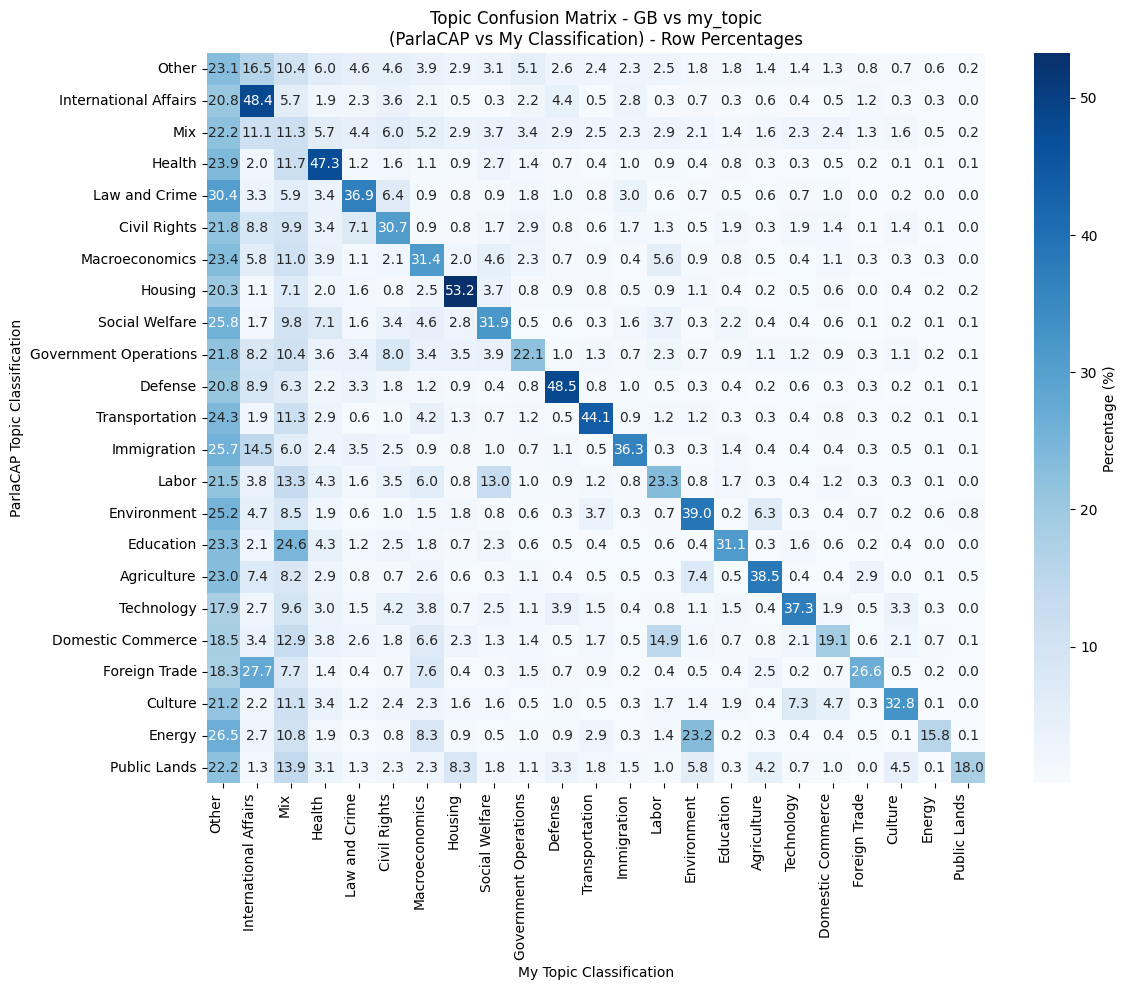


📊 Raw confusion matrix (for reference):
Rows: ParlaCAP topics, Columns: My topics
my_topic               Other  International Affairs    Mix  Health  \
my_topic                                                             
Other                  22227                  15839  10000    5821   
International Affairs  16853                  39281   4620    1568   
Mix                    11816                   5887   5984    3035   
Health                 13743                   1157   6748   27194   
Law and Crime          14413                   1581   2782    1598   
Civil Rights            5862                   2381   2655     924   
Macroeconomics          6117                   1503   2875    1012   
Housing                 4730                    251   1645     465   
Social Welfare          6096                    408   2317    1675   
Government Operations   6876                   2593   3291    1121   
Defense                 4024                   1725   1221     423   
Transpo

In [42]:
# === TOPIC COMPARISON AND OVERLAP ANALYSIS ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

def analyze_topic_overlap(df, my_topic_col, ParlaCAP_topic_column, dataset_name):
    """
    Analyze overlap between my topic classification and reference topic classification
    """
    print(f"\n🔍 Topic Overlap Analysis for {dataset_name}")
    print("=" * 60)

    print(f"📊 Analyzing {len(df):,} valid segments")

    # Basic statistics
    my_topics = df[my_topic_col]
    parlacap_topics = df[ParlaCAP_topic_column]
    
    print(f"\n📈 Basic Statistics:")
    print(f"   • My topics - Unique: {my_topics.nunique()}, Most common: {my_topics.mode().iloc[0]}")
    print(f"   • ParlaCAP topics - Unique: {parlacap_topics.nunique()}, Most common: {parlacap_topics.mode().iloc[0]}")

    # Exact match accuracy
    exact_matches = (my_topics == parlacap_topics).sum()
    accuracy = exact_matches / len(df)
    print(f"\n🎯 Exact Match Accuracy: {accuracy:.3f} ({exact_matches:,}/{len(df):,})")
    
    # Cross-tabulation
    crosstab = pd.crosstab(my_topics, parlacap_topics, margins=True)
    print(f"\n📋 Cross-tabulation (Top 10x10):")
    # Show top 10 most common categories from each
    my_top = my_topics.value_counts().index
    parlacap_top = parlacap_topics.value_counts().index
    print(crosstab.loc[my_top, parlacap_top])
    
    # Agreement matrix (percentage)
    agreement_matrix = pd.crosstab(my_topics, parlacap_topics, normalize='index') * 100

    # Find best matches for each of my topics
    print(f"\n🔗 Best Matches for My Topics:")
    for topic in my_topics.value_counts().index:
        if topic in agreement_matrix.index:
            best_match = agreement_matrix.loc[topic].idxmax()
            best_score = agreement_matrix.loc[topic].max()
            topic_count = my_topics.value_counts()[topic]
            print(f"   • {topic} → {best_match} ({best_score:.1f}%, n={topic_count})")
    
    # Create confusion matrix for visualization
    plt.figure(figsize=(12, 10))
    
    # Limit to top categories for readability
    my_top_cats = my_topics.value_counts().index
    parlacap_top_cats = parlacap_topics.value_counts().index
    
    # Filter data to top categories
    filtered_data = df[
        (df[my_topic_col].isin(my_top_cats)) & 
        (df[ParlaCAP_topic_column].isin(parlacap_top_cats))
    ]
    
    if len(filtered_data) > 0:
        # Use the same ordering for both axes - based on frequency in my topics
        my_top_cats = my_topics.value_counts().index
        parlacap_top_cats = parlacap_topics.value_counts().index
        
        # Create confusion matrix with consistent ordering
        conf_matrix = confusion_matrix(
            filtered_data[ParlaCAP_topic_column], 
            filtered_data[my_topic_col],
            labels=my_top_cats  # Use same order for both
        )
        
        # Convert to percentages (normalize by row - ParlaCAP categories)
        conf_matrix_pct = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
        
        sns.heatmap(conf_matrix_pct, 
                   xticklabels=my_top_cats, 
                   yticklabels=my_top_cats,  # Use same order for y-axis
                   annot=True, 
                   fmt='.1f',  # Show 1 decimal place for percentages
                   cmap='Blues',
                   cbar_kws={'label': 'Percentage (%)'})
        plt.title(f'Topic Confusion Matrix - {dataset_name}\n(ParlaCAP vs My Classification) - Row Percentages')
        plt.xlabel('My Topic Classification')
        plt.ylabel('ParlaCAP Topic Classification')
        plt.xticks(rotation=90, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Also show raw counts for reference
        print(f"\n📊 Raw confusion matrix (for reference):")
        print(f"Rows: ParlaCAP topics, Columns: My topics")
        print(pd.DataFrame(conf_matrix, 
                          index=my_top_cats,  # Use same order for consistency
                          columns=my_top_cats))

    # Return summary statistics
    return {
        'accuracy': accuracy,
        'total_segments': len(df),
        'exact_matches': exact_matches,
        'my_unique_topics': my_topics.nunique(),
        'parlacap_unique_topics': parlacap_topics.nunique(),
        'crosstab': crosstab,
        'agreement_matrix': agreement_matrix
    }

# Check what topic columns are available in GB dataset
print("📋 Available columns in GB_processed:")
topic_cols = [col for col in GB_processed.columns if 'topic' in col.lower()]
print(f"Topic-related columns: {topic_cols}")


gb_analysis = analyze_topic_overlap(
            GB_processed, 
            'my_topic', 
            'Topic', 
            f'GB vs my_topic'
        )

print("📊 My topic distribution:")
print(GB_processed['my_topic'].value_counts())

📊 Parameter Analysis for GB
Current Results:
   • Outliers (-1): 142170 (21.2%)
   • Mix assignments (-2): 66685 (9.9%)
   • High-confidence topics: 462057 (68.9%)

Confidence Statistics:
count     6.709120e+05
mean      2.948688e-01
std       3.945307e-01
min      9.816262e-307
25%       1.874077e-02
50%       7.519587e-02
75%       4.229901e-01
max       1.000000e+00
Name: Segment_Topic_Confidence_GB_english, dtype: float64


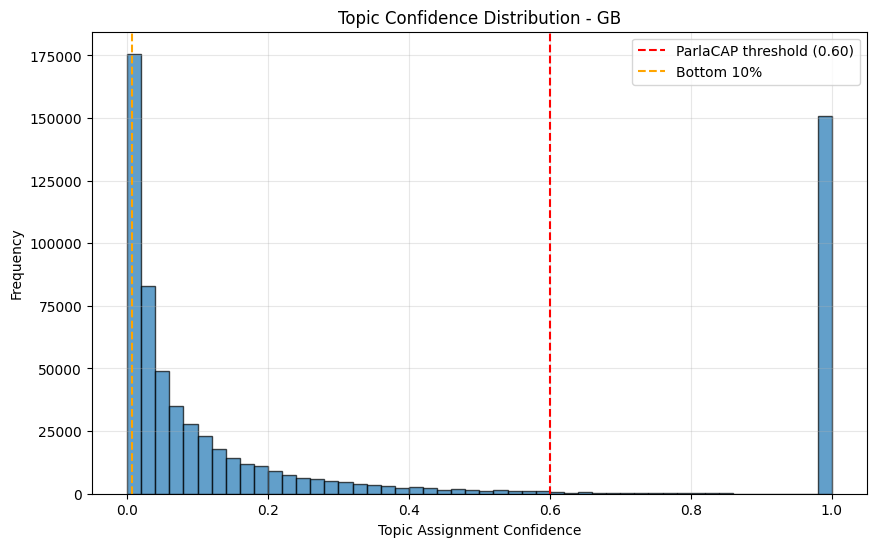


💡 Parameter Tuning Recommendations:
   • To REDUCE outliers: decrease cluster_selection_epsilon (try 0.02-0.05)
   • To INCREASE outliers: increase cluster_selection_epsilon (try 0.15-0.20)
   • Current setting: cluster_selection_epsilon=0.05
   • Lower min_cluster_size also reduces outliers but may create too many small clusters


In [34]:
# === PARAMETER TUNING HELPER ===
def analyze_clustering_parameters(dataset_name="GB"):
    """
    Analyze the effect of different clustering parameters on outlier percentage
    """
    print(f"📊 Parameter Analysis for {dataset_name}")
    print("=" * 50)
    
    if dataset_name == "GB":
        outlier_col = 'Segment_Topic_GB_english'
        mix_col = 'Segment_Is_Mix_GB_english'
        conf_col = 'Segment_Topic_Confidence_GB_english'
        df = GB_processed
    
    # Current results
    outliers = (df[outlier_col] == -1).sum()
    mix_assignments = df[mix_col].sum() if mix_col in df.columns else 0
    high_conf = (df[outlier_col] >= 0).sum()
    total = len(df)
    
    print(f"Current Results:")
    print(f"   • Outliers (-1): {outliers} ({outliers/total*100:.1f}%)")
    print(f"   • Mix assignments (-2): {mix_assignments} ({mix_assignments/total*100:.1f}%)")
    print(f"   • High-confidence topics: {high_conf} ({high_conf/total*100:.1f}%)")
    
    if conf_col in df.columns:
        confidence_stats = df[conf_col].describe()
        print(f"\nConfidence Statistics:")
        print(confidence_stats)
        
        # Show confidence distribution
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.hist(df[conf_col], bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(0.60, color='red', linestyle='--', label='ParlaCAP threshold (0.60)')
        plt.axvline(df[conf_col].quantile(0.10), color='orange', linestyle='--', label='Bottom 10%')
        plt.xlabel('Topic Assignment Confidence')
        plt.ylabel('Frequency')
        plt.title(f'Topic Confidence Distribution - {dataset_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print(f"\n💡 Parameter Tuning Recommendations:")
    print(f"   • To REDUCE outliers: decrease cluster_selection_epsilon (try 0.02-0.05)")
    print(f"   • To INCREASE outliers: increase cluster_selection_epsilon (try 0.15-0.20)")
    print(f"   • Current setting: cluster_selection_epsilon=0.05")
    print(f"   • Lower min_cluster_size also reduces outliers but may create too many small clusters")

# Run analysis for current results
if 'GB_processed' in locals():
    analyze_clustering_parameters("GB")


🇭🇷 CROATIAN PARLIAMENT (HR) - ENGLISH VERSION ANALYSIS
📋 Available columns in HR_processed:
Topic-related columns: ['Topic', 'Segment_Topic_HR_english', 'Segment_Subtopic_HR_english', 'Segment_Topic_Confidence_HR_english', 'Segment_Original_Topic_HR_english', 'Segment_Topic_HR_croatian', 'Segment_Subtopic_HR_croatian', 'Segment_Topic_Confidence_HR_croatian', 'Segment_Original_Topic_HR_croatian', 'my_subtopic_en', 'my_topic_en', 'my_subtopic_native_language', 'my_topic_native_language']

🔍 Topic Overlap Analysis for HR vs my_topic_en
📊 Analyzing 504,338 valid segments

📈 Basic Statistics:
   • My topics - Unique: 23, Most common: Other
   • ParlaCAP topics - Unique: 24, Most common: Other

🎯 Exact Match Accuracy: 0.277 (139,593/504,338)

📋 Cross-tabulation (Top 10x10):
Topic                  Other  Government Operations  Macroeconomics   Mix  \
my_topic_en                                                                 
Other                  46947                   4362            516

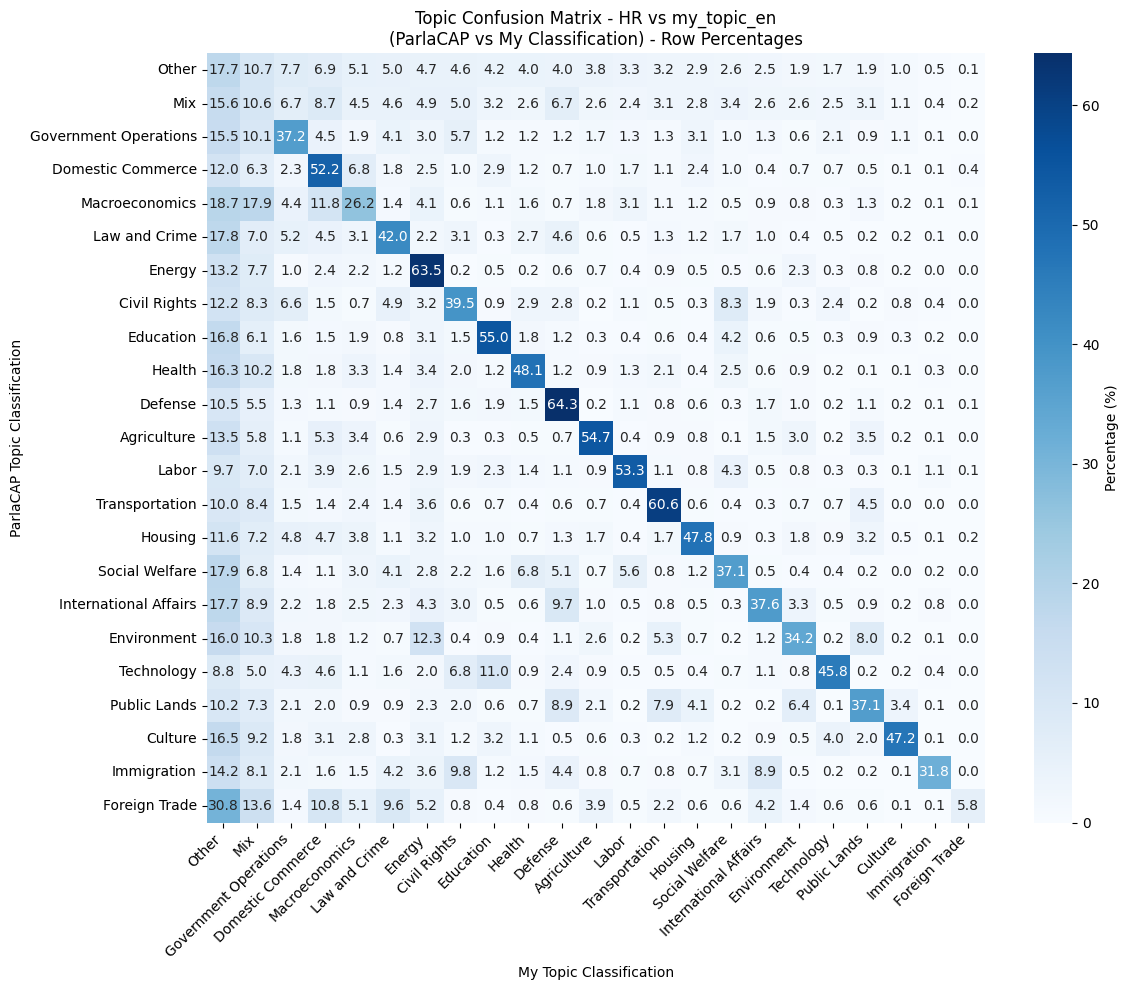


📊 Raw confusion matrix (for reference):
Rows: ParlaCAP topics, Columns: My topics
my_topic_en            Other    Mix  Government Operations  Domestic Commerce  \
my_topic_en                                                                     
Other                  46947  28264                  20308              18401   
Mix                     3901   2657                   1674               2167   
Government Operations   4362   2852                  10454               1262   
Domestic Commerce       1671    876                    326               7264   
Macroeconomics          5164   4948                   1227               3255   
Law and Crime           2924   1147                    860                731   
Energy                   614    358                     46                110   
Civil Rights            1668   1132                    908                207   
Education               1865    674                    177                167   
Health                  20

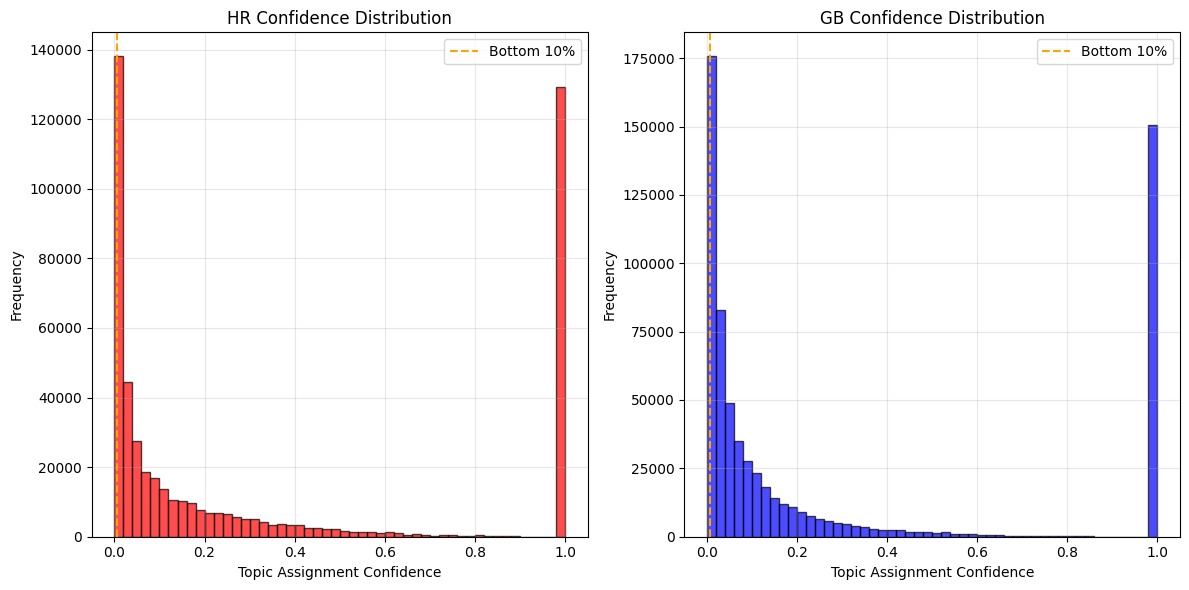


📊 Summary Comparison:
   • HR Accuracy: 0.277
   • GB Accuracy: 0.330
   • HR Total segments: 504,338
   • GB Total segments: 670,912


In [37]:
# === HR DATASET TOPIC OVERLAP ANALYSIS ===
print("\n" + "="*80)
print("🇭🇷 CROATIAN PARLIAMENT (HR) - ENGLISH VERSION ANALYSIS")
print("="*80)

# Check what topic columns are available in HR dataset
print("📋 Available columns in HR_processed:")
hr_topic_cols = [col for col in HR_processed.columns if 'topic' in col.lower()]
print(f"Topic-related columns: {hr_topic_cols}")

# Run the same analysis for HR dataset (English version)
hr_analysis = analyze_topic_overlap(
            HR_processed, 
            'my_topic_en',  # HR English topic classification
            'Topic',        # ParlaCAP reference topic
            'HR vs my_topic_en'
        )

print("\n📊 HR My topic distribution (English):")
print(HR_processed['my_topic_en'].value_counts())

print("\n📊 HR ParlaCAP topic distribution:")
print(HR_processed['Topic'].value_counts())

# Additional analysis - compare confidence distributions between datasets
print(f"\n📈 Confidence Comparison (HR vs GB):")
if 'Segment_Topic_Confidence_HR_english' in HR_processed.columns and 'Segment_Topic_Confidence_GB_english' in GB_processed.columns:
    hr_conf = HR_processed['Segment_Topic_Confidence_HR_english']
    gb_conf = GB_processed['Segment_Topic_Confidence_GB_english']
    
    print(f"   • HR confidence - Mean: {hr_conf.mean():.3f}, Std: {hr_conf.std():.3f}")
    print(f"   • GB confidence - Mean: {gb_conf.mean():.3f}, Std: {gb_conf.std():.3f}")
    
    # Plot confidence distributions comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(hr_conf, bins=50, alpha=0.7, edgecolor='black', color='red')
    plt.axvline(hr_conf.quantile(0.10), color='orange', linestyle='--', label='Bottom 10%')
    plt.xlabel('Topic Assignment Confidence')
    plt.ylabel('Frequency')
    plt.title('HR Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(gb_conf, bins=50, alpha=0.7, edgecolor='black', color='blue')
    plt.axvline(gb_conf.quantile(0.10), color='orange', linestyle='--', label='Bottom 10%')
    plt.xlabel('Topic Assignment Confidence')
    plt.ylabel('Frequency')
    plt.title('GB Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n📊 Summary Comparison:")
print(f"   • HR Accuracy: {hr_analysis['accuracy']:.3f}")
print(f"   • GB Accuracy: {gb_analysis['accuracy']:.3f}")
print(f"   • HR Total segments: {hr_analysis['total_segments']:,}")
print(f"   • GB Total segments: {gb_analysis['total_segments']:,}")